# IBM models from NLTK

~~We test the IBM models with ETP, CIEP, both.~~

We test the IBM models on ETP.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from nltk.translate import IBMModel1, IBMModel2, IBMModel3, IBMModel4, IBMModel5, AlignedSent, PhraseTable
from nltk import WhitespaceTokenizer
import nltk
from typing import Iterable, Any, List, Tuple, Optional
from collections import defaultdict
import sys
sys.path.append("..")
import Data
import translation_utils
from Data import utils
import re

In [2]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gianluca/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
title_re = re.compile(r"[^a-zA-Z ]*((mr)|(ms)|(mrs)|(miss))[^a-zA-Z ]*")
remove_chars = re.compile(r"[126\[\],<>]:;/")
space_norm = re.compile(r" +")
add_unk = re.compile(r"\?")
dash = re.compile(r"(?<=[a-zA-Z0-9])-(?=[a-zA-Z0-9])")
symbols = re.compile(r"[\(\),\.<>]")

def clean_english(x: str) -> str:
    x = utils.replace(x, utils.to_latin)
    x = x.lower()
    x = title_re.sub(" ", x)
    x = dash.sub(" ", x)
    x = remove_chars.sub(" ", x)
    x = add_unk.sub(" ", x)    
    x = symbols.sub(" ", x)
    x = space_norm.sub(" ", x)
    return x.strip()

def clean_etruscan(x: str) -> str:
    x = x.lower()
    x = remove_chars.sub(" ", x)
    x = space_norm.sub(" ", x)
    return x.strip()

In [4]:
data = pd.read_csv("../Data/Etruscan.csv", index_col=0)
data = data.dropna(subset=["Translation"]).reset_index()
data["Etruscan"] = data["Etruscan"].apply(lambda x: utils.replace(x, utils.to_latin)).apply(clean_etruscan)
data["Translation"] = data["Translation"].apply(clean_english)
data

,index,ID,City,Year - From,Year - To,Etruscan,Translation,key
0,0,ETP 192,Ager Tarquiniensis,275.0,250.0,cleusinas laris larisal clan,laris cleusinas son of laris,NaN
1,1,Cr 2.20,Caere,675.0,650.0,mi karkanas thahvna,i am the container of karkana,NaN
2,2,Cm 2.46,Campania,500.0,450.0,mi ei minpi capi mi numar thevruclnas qupes fu...,dont take me i am nunar i am the property of q...,NaN
3,3,ETP 269,NaN,625.0,600.0,mini muluvanice tetana velkasnas veleliiasi,tetana velkasnas gave me to velellia,NaN
4,4,Ta 3.2,Tarquinia,580.0,580.0,itun turuce venel atelinas tinas dlniiaras,venel atelinas dedicated this vase to the sons...,NaN
...,...,...,...,...,...,...,...,...
2886,5783,20601,NaN,NaN,NaN,felies,felies,1A
2887,5784,20607,NaN,NaN,NaN,numi,theslovenlywriter numi,1B
2888,5791,20709,NaN,NaN,NaN,numas,numas,1B
2889,5809,20899,NaN,NaN,NaN,kramuries,kramuries,1


In [5]:
etp_data = data[data["key"].isna()]
ciep_data = data.dropna(subset=["key"])

In [6]:
wt = WhitespaceTokenizer()
etp_etruscan_sent = etp_data["Etruscan"].apply(wt.tokenize).to_list()
etp_english_sent = etp_data["Translation"].apply(wt.tokenize).to_list()
ciep_etruscan_sent = ciep_data["Etruscan"].apply(wt.tokenize).to_list()
ciep_english_sent = ciep_data["Translation"].apply(wt.tokenize).to_list()

etruscan_sent = data["Etruscan"].apply(wt.tokenize).to_list()
english_sent = data["Translation"].apply(wt.tokenize).to_list()

In [7]:
vocab = Data.load_pos("../Data/ETP_POS.csv")
vocab["Etruscan"] = vocab["Etruscan"].apply(lambda x: utils.replace(x, utils.to_latin)).apply(clean_etruscan)
vocab

,Etruscan,Translations,POS,Is inferred,Is suffix,Abbreviation of,Suffix indexes,city name,place name,name,...,1st pert,2nd pert,1st pers,2nd pers,3rd pers,pl,gen,abl,pert,TAG
0,isa,"((True, the),)",def art nom,False,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,False,False,False,ADP
1,isha,"((True, the),)",def art nom,False,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,False,False,False,PRON
2,x,"((True, and),)",enclitic conj,False,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,PRT
3,ishla,"((True, the),)",def art 2nd gen,False,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,True,False,False,DET
4,cle,"((True, the),)",dem pro loc,False,True,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,False,False,False,ADP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,fleres,"((True, divine spirit), (True, divinity))",1st gen,False,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,True,False,False,NOUN
1118,flerthrce,(),past act,False,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,VERB
1119,fratuce,"((False, incised),)",past act,False,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,VERB
1120,frontac,"((True, of lightning),)",nom acc,False,False,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,False,False,False,ADJ


In [8]:
src_classes = defaultdict(lambda: np.nan)
trg_classes = defaultdict(lambda: np.nan)
for i in vocab.iloc:
    src_classes[clean_etruscan(i["Etruscan"])] = i["TAG"]
    for t in i["Translations"]:
        tmp = clean_english(t[1])
        tag = nltk.pos_tag([tmp])[0][0] 
        trg_classes[tmp] = tag

In [9]:
phrase_table = PhraseTable()
sentences = []
for row in vocab.iloc:
    et = clean_etruscan(row["Etruscan"])
    for i in row["Translations"]:
        tmp = clean_english(i[1])
        phrase_table.add(tuple(wt.tokenize(et)), tuple(wt.tokenize(tmp)), np.log(1/len(row["Translations"])))
        sentences.append(AlignedSent(wt.tokenize(et), wt.tokenize(tmp)))

In [10]:
def greedy_decoding(text: Iterable[str], model, unk_translation: Optional[str] = None) -> Tuple[List[str], float]:
    translation = []
    logprob = 0
    for i in text:
        dist = model.translation_table[i].items()
        unk = False
        if len(dist) == 0:  # unknown word
            unk = True
        else:
            token, token_prob = max(dist, key=lambda x: x[1])
            if token is None:
                unk = True
            else:
                translation.append(token)
            logprob += np.log(token_prob)
        if unk and unk_translation is not None:
            translation.append(unk_translation)
    return translation, logprob

def random_split(english: List[List[str]], etruscan: List[List[str]], ratio: float, rng: np.random.RandomState) -> Tuple[List[List[str]], List[List[str]], List[List[str]], List[List[str]]]:
    indexes = np.arange(len(english))
    rng.shuffle(indexes)
    split = int(np.round(ratio * len(indexes)))
    
    # tmp_eng = np.array(english)
    # tmp_et = np.array(etruscan)
    
    # train_eng = tmp_eng[indexes[:split]]
    # train_et = tmp_et[indexes[:split]]

    # test_eng = tmp_eng[indexes[split:]]
    # test_et = tmp_et[indexes[split:]]

    train_eng = []
    train_et = []
    for i in indexes[:split]:
        train_eng.append(english[i])
        train_et.append(etruscan[i])

    test_eng = []
    test_et = []
    for i in indexes[split:]:
        test_eng.append(english[i])
        test_et.append(etruscan[i])

    return train_et, train_eng, test_et, test_eng

def make_sentences(eng: List[List[str]], et: List[List[str]]):
    sentences = [None] * len(eng)
    phrase_table = PhraseTable()
    for i, (j, k) in enumerate(zip(eng, et)):
        phrase_table.add(tuple(k), tuple(j), 0)
        sentences[i] = AlignedSent(k, j)
    return sentences, phrase_table

def ibm1_factory(sentences, *args):
    return IBMModel1(sentences, 5)

def ibm2_factory(sentences, *args):
    return IBMModel2(sentences, 5)

def ibm3_factory(sentences, *args):
    return IBMModel3(sentences, 5)

def ibm4_factory(sentences, src, trg):
    return IBMModel4(sentences, 5, src, trg)

def ibm5_factory(sentences, src, trg):
    return IBMModel5(sentences, 5, src, trg)

def run_experiment(model_factory, sentences, test_et, test_eng, examples: int = 1, join_str:str=" "):
    model = model_factory(sentences, src_classes, trg_classes)   
    
    test_eng = [join_str.join(i) for i in test_eng]
    pred = []
    for i in test_et:
        pred.append(join_str.join(greedy_decoding(i, model)[0]))
    
    scores = translation_utils.compute_metrics(pred, test_eng)
    ex = (test_et[:examples], test_eng[:examples], pred[:examples])
    return scores, ex

def run_n_experiments(model_factory, et, eng, vocab_sent, only_vocab=False, n: int = 10, seed: int = 0, join_str: str = " "):
    results = defaultdict(list)
    rng = np.random.RandomState(seed)

    for _ in tqdm(range(n), total=n):
        train_et, train_eng, test_et, test_eng = random_split(eng, et, 0.8, rng)
        
        if only_vocab:
            train = vocab_sent
        else:
            train, _ = make_sentences(train_eng, train_et)  
            train = train + vocab_sent          
        tmp_res, example = run_experiment(model_factory, train, test_et, test_eng, join_str=join_str)
        for i, j in tmp_res.items():
            results[i].append(j)
    
    return results, example

def print_stats(results):
    df = pd.DataFrame(results)
    print("Mean:")
    print(df.mean())
    print("Standard deviation:")
    print(df.std())

In [11]:
def run_ibm(et, eng, factory, output, title, only_vocab=False, join_str: str = " "):
    results, example = run_n_experiments(factory, et, eng, sentences, only_vocab, join_str=join_str)

    with open(output, "w") as f:
        json.dump(results, f)
    
    print_stats(results)
    
    translation_utils.print_example(example)

    translation_utils.plot_results(results, title)

## ETP

100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Mean:
bleu     2.186709
chrf    37.362712
ter     73.917326
dtype: float64
Standard deviation:
bleu    0.596350
chrf    2.011458
ter     2.162743
dtype: float64
------------------------------------------------------------
Etruscan: ['eca', 'shuthic', 'velus', 'ezpus', 'clensi', 'cerine']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: ersce funerary rapi etspus erected is
------------------------------------------------------------


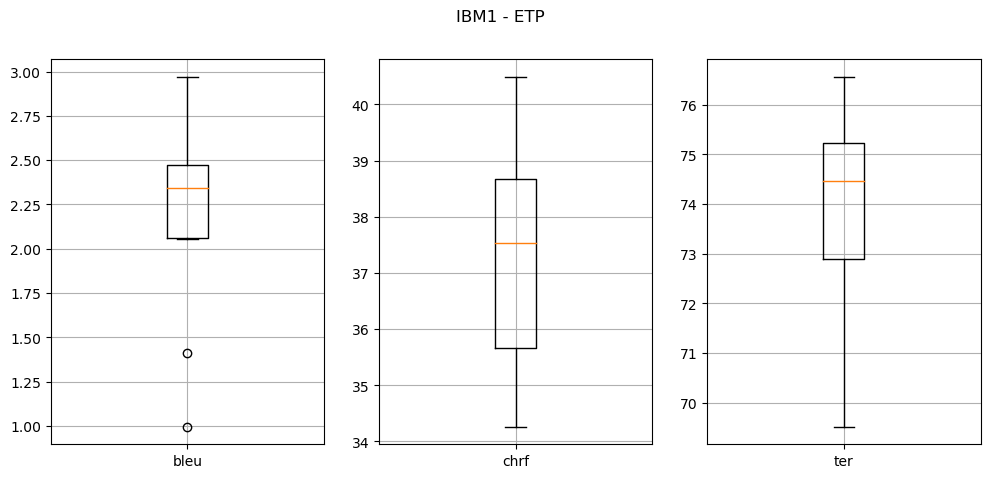

In [12]:
run_ibm(etp_etruscan_sent, etp_english_sent, ibm1_factory, "Results/ibm1_etp.json", "IBM1 - ETP")

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Mean:
bleu     2.103890
chrf    36.720839
ter     74.334105
dtype: float64
Standard deviation:
bleu    0.449315
chrf    2.097871
ter     2.090324
dtype: float64
------------------------------------------------------------
Etruscan: ['eca', 'shuthic', 'velus', 'ezpus', 'clensi', 'cerine']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: flerthrce funerary vel etspus erected constructed
------------------------------------------------------------


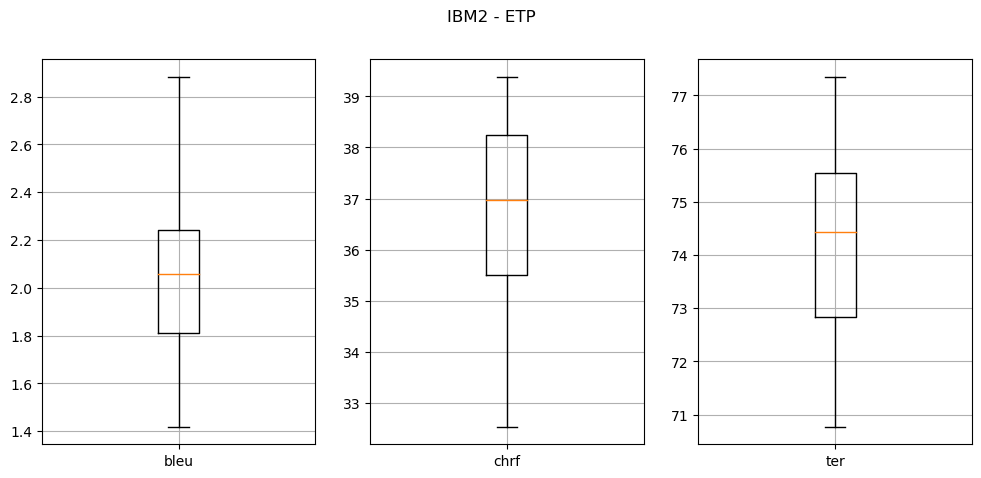

In [13]:
run_ibm(etp_etruscan_sent, etp_english_sent, ibm2_factory, "Results/ibm2_etp.json", "IBM2 - ETP")

100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Mean:
bleu     2.482783
chrf    39.393073
ter     71.270120
dtype: float64
Standard deviation:
bleu    0.513781
chrf    2.229150
ter     2.455685
dtype: float64
------------------------------------------------------------
Etruscan: ['eca', 'shuthic', 'velus', 'ezpus', 'clensi', 'cerine']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: this funerary vel etspus son constructed
------------------------------------------------------------


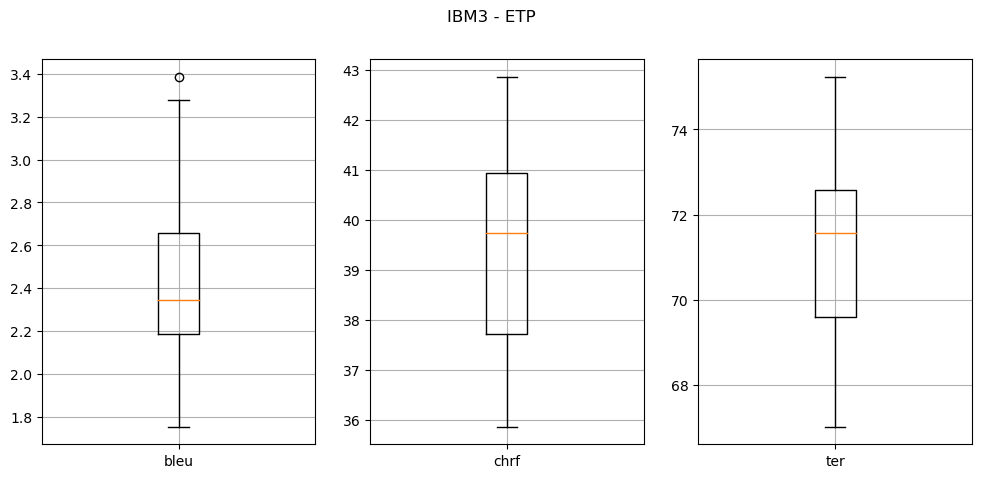

In [23]:
run_ibm(etp_etruscan_sent, etp_english_sent, ibm3_factory, "Results/ibm3_etp.json", "IBM3 - ETP", only_vocab=True)

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Mean:
bleu     2.482783
chrf    39.391630
ter     71.270120
dtype: float64
Standard deviation:
bleu    0.513781
chrf    2.227863
ter     2.455685
dtype: float64
------------------------------------------------------------
Etruscan: ['eca', 'shuthic', 'velus', 'ezpus', 'clensi', 'cerine']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: this funerary vel etspus son constructed
------------------------------------------------------------


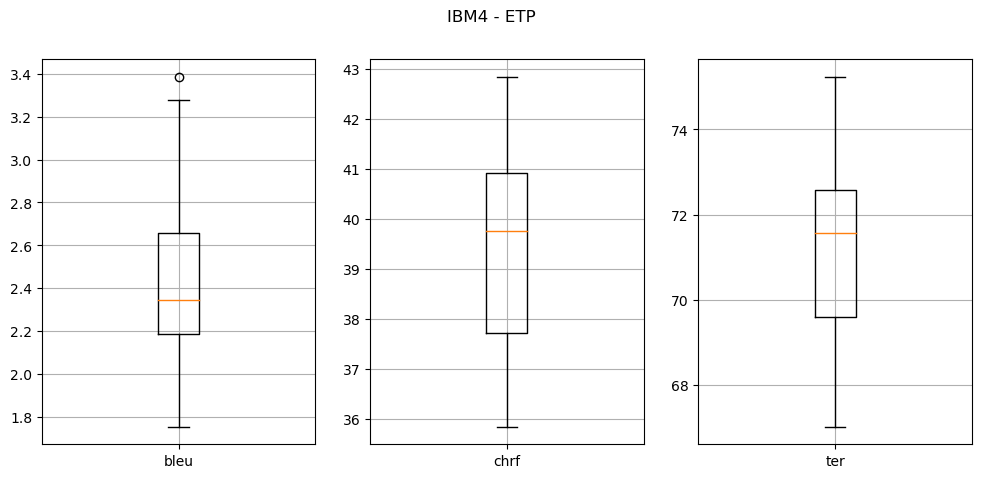

In [15]:
run_ibm(etp_etruscan_sent, etp_english_sent, ibm4_factory, "Results/ibm4_etp.json", "IBM4 - ETP", only_vocab=True)

100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Mean:
bleu     2.481155
chrf    39.415679
ter     71.330940
dtype: float64
Standard deviation:
bleu    0.513404
chrf    2.234776
ter     2.411417
dtype: float64
------------------------------------------------------------
Etruscan: ['eca', 'shuthic', 'velus', 'ezpus', 'clensi', 'cerine']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: this funerary vel etspus son constructed
------------------------------------------------------------


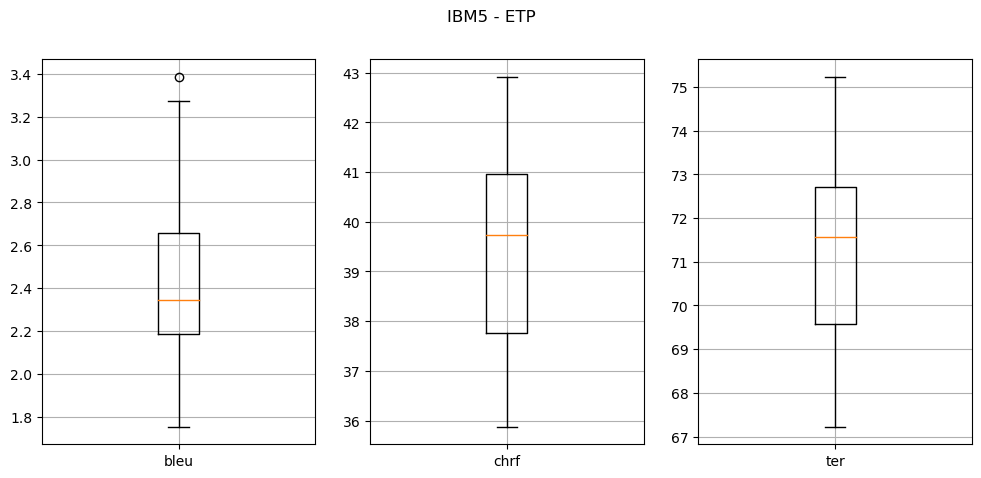

In [16]:
run_ibm(etp_etruscan_sent, etp_english_sent, ibm5_factory, "Results/ibm5_etp.json", "IBM5 - ETP", only_vocab=True)

## Both

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Mean:
bleu     0.401788
chrf    19.743699
ter     89.213355
dtype: float64
Standard deviation:
bleu    0.182625
chrf    1.177878
ter     0.693548
dtype: float64
------------------------------------------------------------
Etruscan: ['lethial']
Reference: s lethis
Prediction: lethis
------------------------------------------------------------


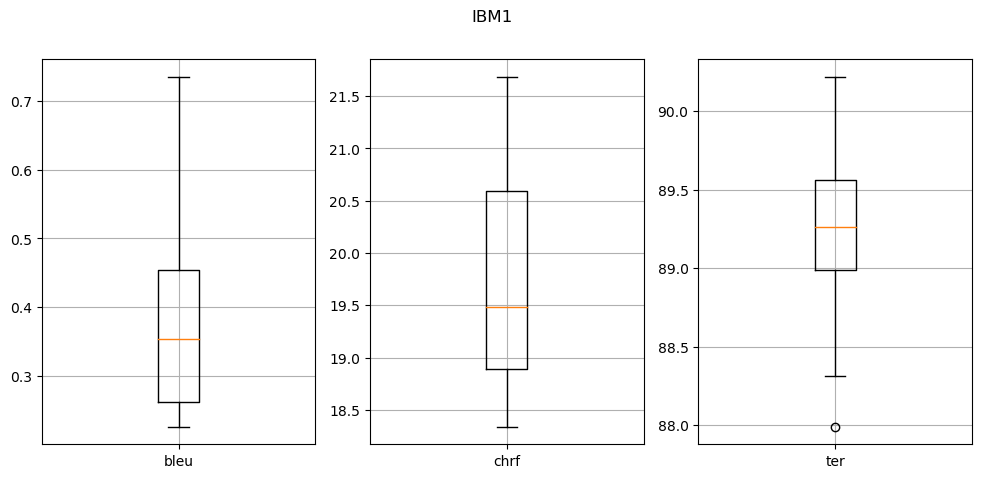

In [17]:
run_ibm(etruscan_sent, english_sent, ibm1_factory, "Results/ibm1.json", "IBM1")

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


Mean:
bleu     0.392238
chrf    19.449852
ter     89.551753
dtype: float64
Standard deviation:
bleu    0.183605
chrf    1.383482
ter     0.487118
dtype: float64
------------------------------------------------------------
Etruscan: ['lethial']
Reference: s lethis
Prediction: lethis
------------------------------------------------------------


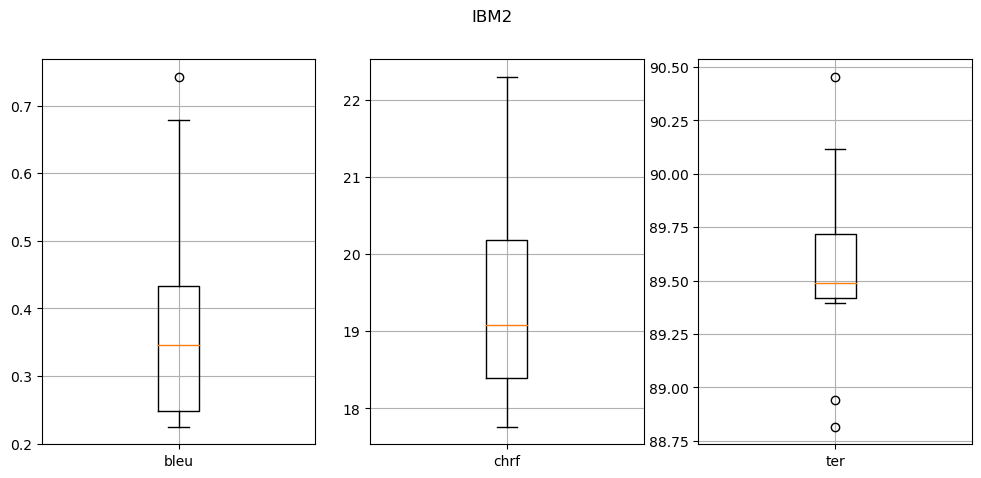

In [18]:
run_ibm(etruscan_sent, english_sent, ibm2_factory, "Results/ibm2.json", "IBM2")

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Mean:
bleu     0.104689
chrf     8.629461
ter     91.051665
dtype: float64
Standard deviation:
bleu    0.045545
chrf    1.147736
ter     1.507070
dtype: float64
------------------------------------------------------------
Etruscan: ['lethial']
Reference: s lethis
Prediction: 
------------------------------------------------------------


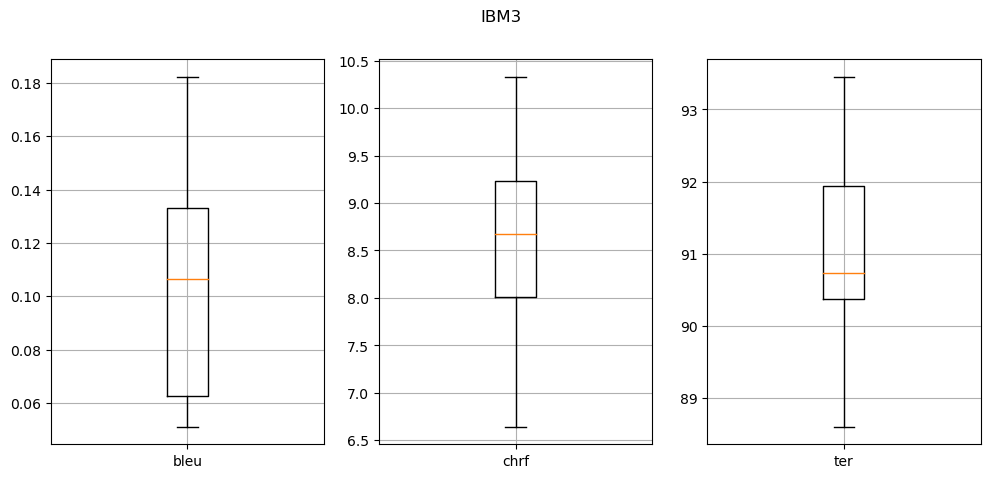

In [19]:
run_ibm(etruscan_sent, english_sent, ibm3_factory, "Results/ibm3.json", "IBM3", only_vocab=True)

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Mean:
bleu     0.104689
chrf     8.626833
ter     91.051665
dtype: float64
Standard deviation:
bleu    0.045545
chrf    1.151372
ter     1.507070
dtype: float64
------------------------------------------------------------
Etruscan: ['lethial']
Reference: s lethis
Prediction: 
------------------------------------------------------------


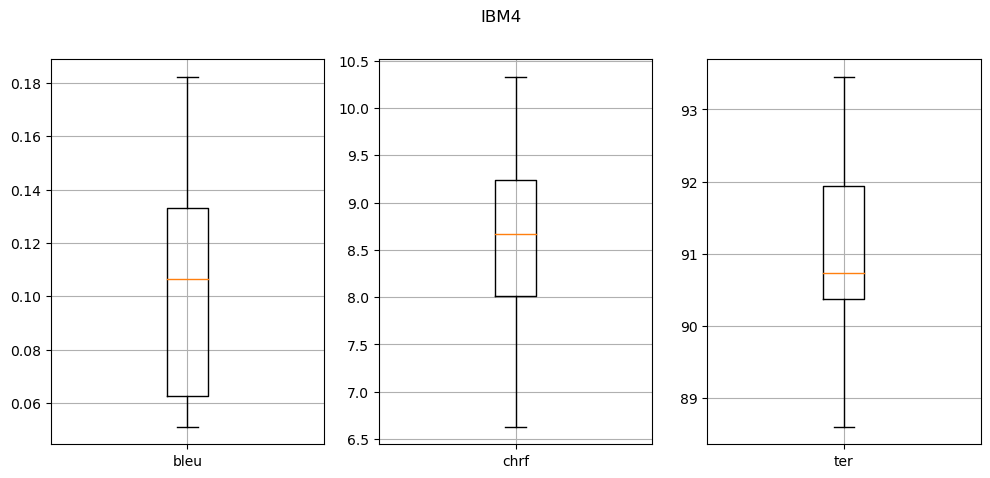

In [20]:
run_ibm(etruscan_sent, english_sent, ibm4_factory, "Results/ibm4.json", "IBM4", only_vocab=True)

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Mean:
bleu     0.104660
chrf     8.631061
ter     91.062743
dtype: float64
Standard deviation:
bleu    0.045556
chrf    1.146591
ter     1.516155
dtype: float64
------------------------------------------------------------
Etruscan: ['lethial']
Reference: s lethis
Prediction: 
------------------------------------------------------------


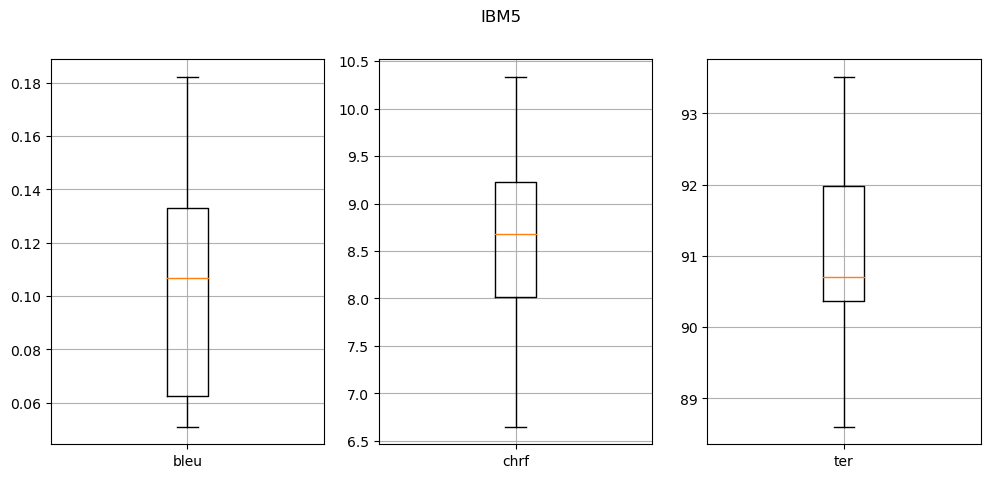

In [21]:
run_ibm(etruscan_sent, english_sent, ibm5_factory, "Results/ibm5.json", "IBM5", only_vocab=True)

# Character based

Try character-to-character and character-to-token.

Exclude IBM4 and IBM5 because we don't have classes for the characters

In [12]:
wt = WhitespaceTokenizer()
etp_etruscan_sent = etp_data["Etruscan"].apply(wt.tokenize).to_list()
etp_etruscan_char = etp_data["Etruscan"].apply(list).to_list()
etp_english_sent = etp_data["Translation"].apply(wt.tokenize).to_list()
etp_english_char = etp_data["Translation"].apply(list).to_list()

etruscan_sent = data["Etruscan"].apply(wt.tokenize).to_list()
english_sent = data["Translation"].apply(wt.tokenize).to_list()
etruscan_char = data["Etruscan"].apply(list).to_list()
english_char = data["Translation"].apply(list).to_list()

In [13]:
char_sentences = [] # char-to-char
tok_sentences = [] # char-to-tok
for row in vocab.iloc:
    et = clean_etruscan(row["Etruscan"])
    for i in row["Translations"]:
        tmp = clean_english(i[1])
        char_sentences.append(AlignedSent(list(et), list(tmp)))
        tok_sentences.append(AlignedSent(list(et), wt.tokenize(tmp)))

In [14]:
def run_ibm(et, eng, factory, output, title, only_vocab=False, use_tok_sentences=False, join_str:str=" "):
    if use_tok_sentences:
        sentences = tok_sentences
    else:
        sentences = char_sentences
    results, example = run_n_experiments(factory, et, eng, sentences, only_vocab, join_str=join_str)

    with open(output, "w") as f:
        json.dump(results, f)
    
    print_stats(results)
    
    translation_utils.print_example(example)

    translation_utils.plot_results(results, title)

### Characters -> Tokens

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Mean:
bleu      0.039970
chrf     13.300935
ter     378.642301
dtype: float64
Standard deviation:
bleu     0.016876
chrf     0.501184
ter     28.923819
dtype: float64
------------------------------------------------------------
Etruscan: ['e', 'c', 'a', ' ', 's', 'h', 'u', 't', 'h', 'i', 'c', ' ', 'v', 'e', 'l', 'u', 's', ' ', 'e', 'z', 'p', 'u', 's', ' ', 'c', 'l', 'e', 'n', 's', 'i', ' ', 'c', 'e', 'r', 'i', 'n', 'e']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: not cae donate shall same four him in four which cae shall shows not donate him same shall not lies celebrated him same shall cae donate not which same which shall cae not make which which not
------------------------------------------------------------


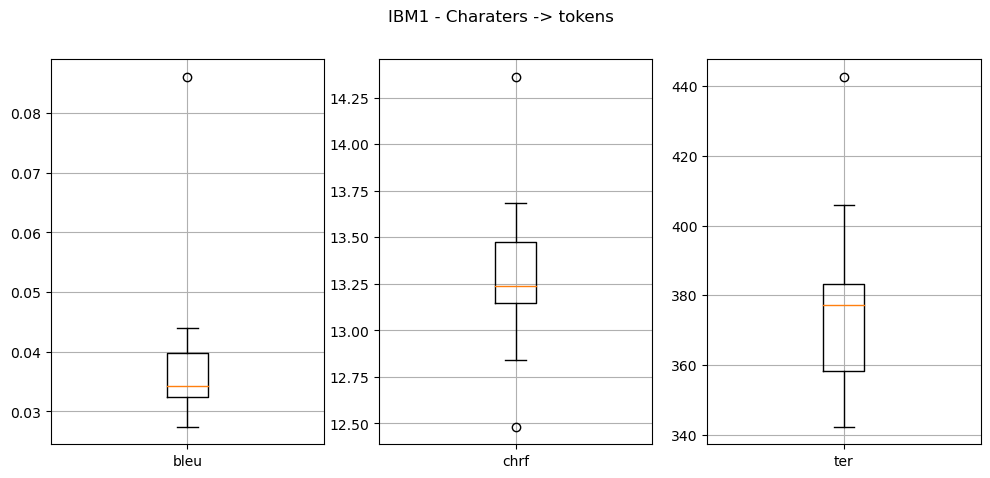

In [37]:
run_ibm(etp_etruscan_char, etp_english_sent, ibm1_factory, "Results/etp_ibm1_c_t.json", "IBM1 - Charaters -> tokens", use_tok_sentences=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:57<00:00,  5.77s/it]


Mean:
bleu      0.043308
chrf     13.534585
ter     378.087037
dtype: float64
Standard deviation:
bleu     0.012864
chrf     0.701607
ter     29.078465
dtype: float64
------------------------------------------------------------
Etruscan: ['e', 'c', 'a', ' ', 's', 'h', 'u', 't', 'h', 'i', 'c', ' ', 'v', 'e', 'l', 'u', 's', ' ', 'e', 'z', 'p', 'u', 's', ' ', 'c', 'l', 'e', 'n', 's', 'i', ' ', 'c', 'e', 'r', 'i', 'n', 'e']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: officiant canla honor shall camthi statue proceeding in statue legal canla shall at officiant should proceeding camthi shall officiant enza herakles proceeding camthi shall canla should officiant both camthi legal shall canla officiant behalf legal both officiant
------------------------------------------------------------


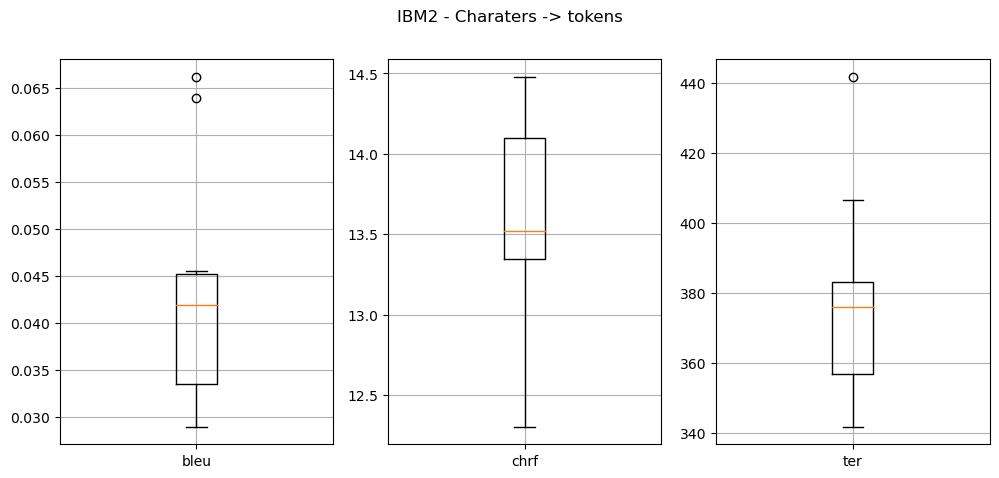

In [38]:
run_ibm(etp_etruscan_char, etp_english_sent, ibm2_factory, "Results/etp_ibm2_c_t.json", "IBM2 - Charaters -> tokens", use_tok_sentences=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [10:52<00:00, 65.21s/it]


Mean:
bleu      0.041653
chrf     14.570562
ter     383.161032
dtype: float64
Standard deviation:
bleu     0.014906
chrf     0.522180
ter     29.918465
dtype: float64
------------------------------------------------------------
Etruscan: ['e', 'c', 'a', ' ', 's', 'h', 'u', 't', 'h', 'i', 'c', ' ', 'v', 'e', 'l', 'u', 's', ' ', 'e', 'z', 'p', 'u', 's', ' ', 'c', 'l', 'e', 'n', 's', 'i', ' ', 'c', 'e', 'r', 'i', 'n', 'e']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: sacrificial cicu father so measurement four area in four that cicu so vuvze sacrificial watch area measurement so sacrificial two celebrated area measurement so cicu watch sacrificial unit measurement that so cicu sacrificial honor that unit sacrificial
------------------------------------------------------------


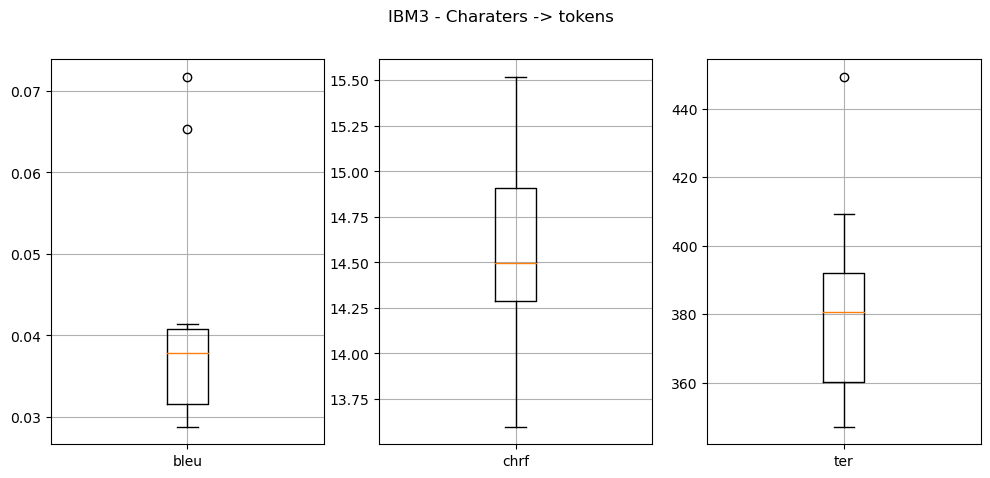

In [39]:
run_ibm(etp_etruscan_char, etp_english_sent, ibm3_factory, "Results/etp_ibm3_c_t.json", "IBM3 - Charaters -> tokens", use_tok_sentences=True, only_vocab=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


Mean:
bleu      0.006036
chrf     12.468705
ter     391.685431
dtype: float64
Standard deviation:
bleu     0.003339
chrf     0.563418
ter     14.022377
dtype: float64
------------------------------------------------------------
Etruscan: ['l', 'e', 't', 'h', 'i', 'a', 'l']
Reference: s lethis
Prediction: velnthis drinking titetute chelus monthsin aulesthe velnthis
------------------------------------------------------------


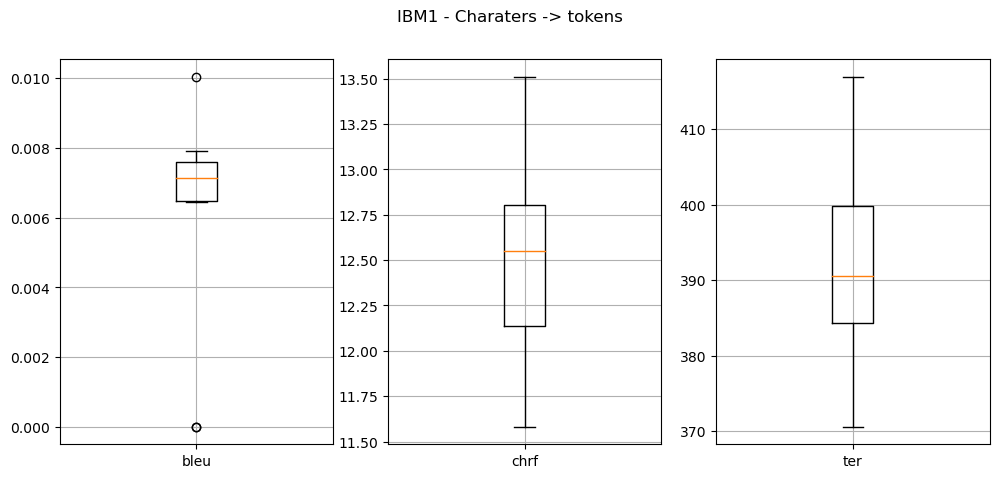

In [40]:
run_ibm(etruscan_char, english_sent, ibm1_factory, "Results/ibm1_c_t.json", "IBM1 - Charaters -> tokens", use_tok_sentences=True)

100%|██████████| 10/10 [01:24<00:00,  8.44s/it]


Mean:
bleu      0.008755
chrf     12.147569
ter     391.457445
dtype: float64
Standard deviation:
bleu     0.001904
chrf     0.776527
ter     13.944372
dtype: float64
------------------------------------------------------------
Etruscan: ['l', 'e', 't', 'h', 'i', 'a', 'l']
Reference: s lethis
Prediction: and--of use titetute sfanusis monthsin aulesthe and--of
------------------------------------------------------------


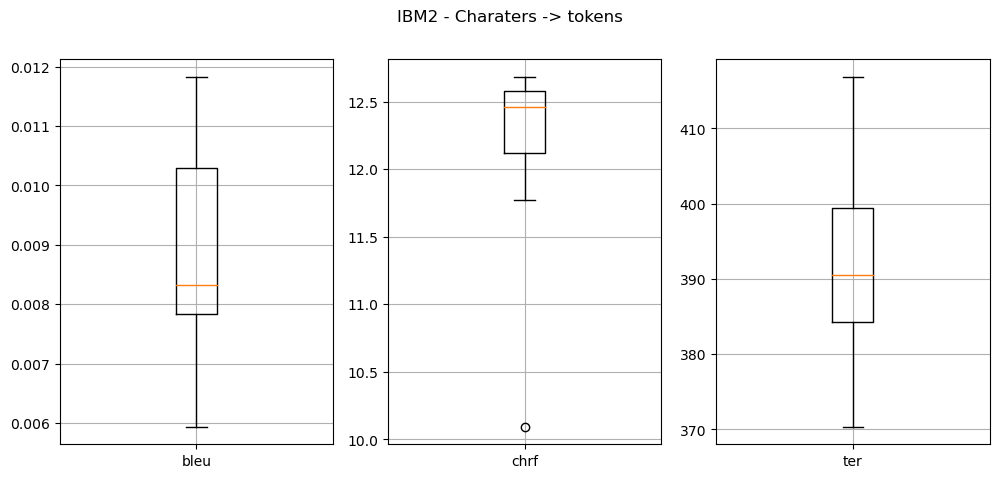

In [41]:
run_ibm(etruscan_char, english_sent, ibm2_factory, "Results/ibm1_c_t.json", "IBM2 - Charaters -> tokens", use_tok_sentences=True)

100%|██████████| 10/10 [11:00<00:00, 66.04s/it]


Mean:
bleu      0.009796
chrf     12.300976
ter     483.838047
dtype: float64
Standard deviation:
bleu     0.003323
chrf     0.326416
ter     35.181387
dtype: float64
------------------------------------------------------------
Etruscan: ['l', 'e', 't', 'h', 'i', 'a', 'l']
Reference: s lethis
Prediction: watch sacrificial in four that father watch
------------------------------------------------------------


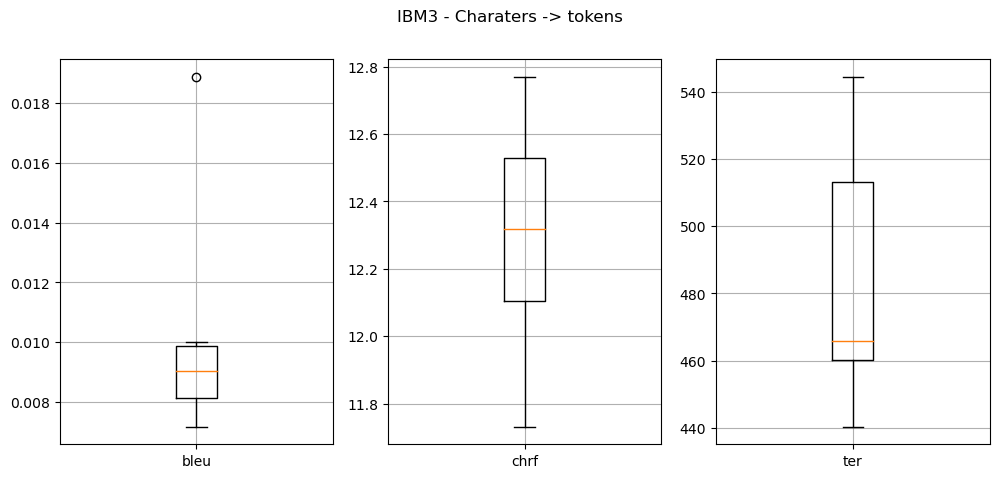

In [42]:
run_ibm(etruscan_char, english_sent, ibm3_factory, "Results/ibm3_c_t.json", "IBM3 - Charaters -> tokens", use_tok_sentences=True, only_vocab=True)

### Characters -> Characters

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Mean:
bleu     1.213196
chrf    30.045999
ter     98.243779
dtype: float64
Standard deviation:
bleu    0.363992
chrf    1.899880
ter     4.026369
dtype: float64
------------------------------------------------------------
Etruscan: ['e', 'c', 'a', ' ', 's', 'h', 'u', 't', 'h', 'i', 'c', ' ', 'v', 'e', 'l', 'u', 's', ' ', 'e', 'z', 'p', 'u', 's', ' ', 'c', 'l', 'e', 'n', 's', 'i', ' ', 'c', 'e', 'r', 'i', 'n', 'e']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: eca shuthic velus ezpus clensi cerine
------------------------------------------------------------


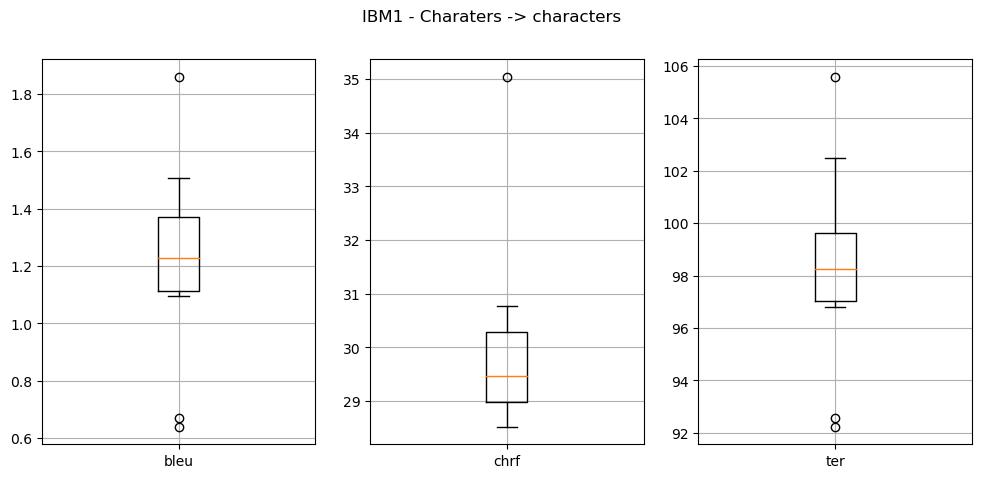

In [43]:
run_ibm(etp_etruscan_char, etp_english_char, ibm1_factory, "Results/etp_ibm1_c_c.json", "IBM1 - Charaters -> characters", use_tok_sentences=False, join_str="")

100%|██████████| 10/10 [05:05<00:00, 30.51s/it]


Mean:
bleu     1.170047
chrf    28.701940
ter     97.555259
dtype: float64
Standard deviation:
bleu    0.374155
chrf    1.999216
ter     3.962441
dtype: float64
------------------------------------------------------------
Etruscan: ['e', 'c', 'a', ' ', 's', 'h', 'u', 't', 'h', 'i', 'c', ' ', 'v', 'e', 'l', 'u', 's', ' ', 'e', 'z', 'p', 'u', 's', ' ', 'c', 'l', 'e', 'n', 's', 'i', ' ', 'c', 'e', 'r', 'i', 'n', 'e']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: eca shuthic velus ezpus clensi cerine
------------------------------------------------------------


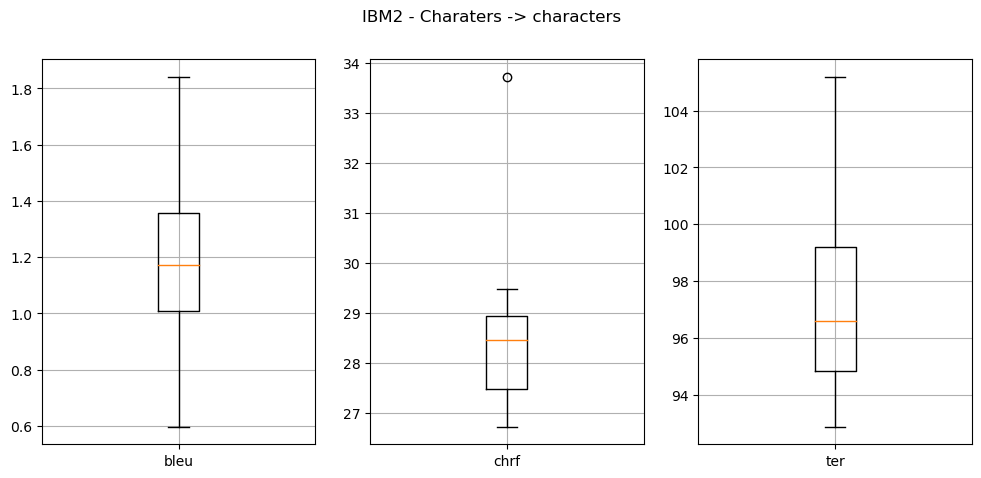

In [44]:
run_ibm(etp_etruscan_char, etp_english_char, ibm2_factory, "Results/etp_ibm2_c_c.json", "IBM2 - Charaters -> characters", use_tok_sentences=False, join_str="")

100%|██████████| 10/10 [4:07:17<00:00, 1483.70s/it] 


Mean:
bleu     0.841710
chrf    27.903923
ter     98.935761
dtype: float64
Standard deviation:
bleu    0.247936
chrf    1.561012
ter     4.025492
dtype: float64
------------------------------------------------------------
Etruscan: ['e', 'c', 'a', ' ', 's', 'h', 'u', 't', 'h', 'i', 'c', ' ', 'v', 'e', 'l', 'u', 's', ' ', 'e', 'z', 'p', 'u', 's', ' ', 'c', 'l', 'e', 'n', 's', 'i', ' ', 'c', 'e', 'r', 'i', 'n', 'e']
Reference: this funerary monument belongs to vel etspu it is constructed by his son
Prediction: eсa shuthiс velus ezpus сlensi сerine
------------------------------------------------------------


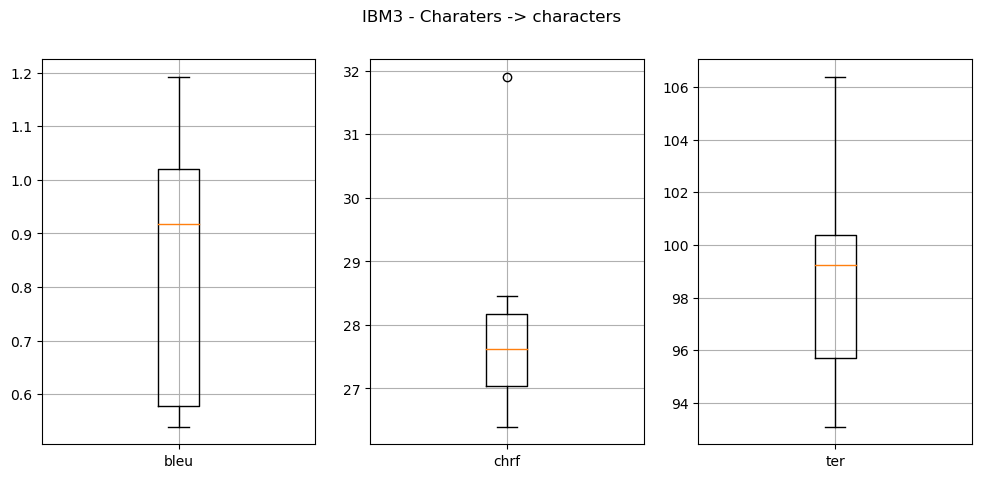

In [15]:
run_ibm(etp_etruscan_char, etp_english_char, ibm3_factory, "Results/etp_ibm3_c_c.json", "IBM3 - Charaters -> characters", use_tok_sentences=False, join_str="", only_vocab=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


Mean:
bleu     0.887708
chrf    20.563236
ter     96.614617
dtype: float64
Standard deviation:
bleu    0.381229
chrf    1.189270
ter     0.883017
dtype: float64
------------------------------------------------------------
Etruscan: ['l', 'e', 't', 'h', 'i', 'a', 'l']
Reference: s lethis
Prediction: lethial
------------------------------------------------------------


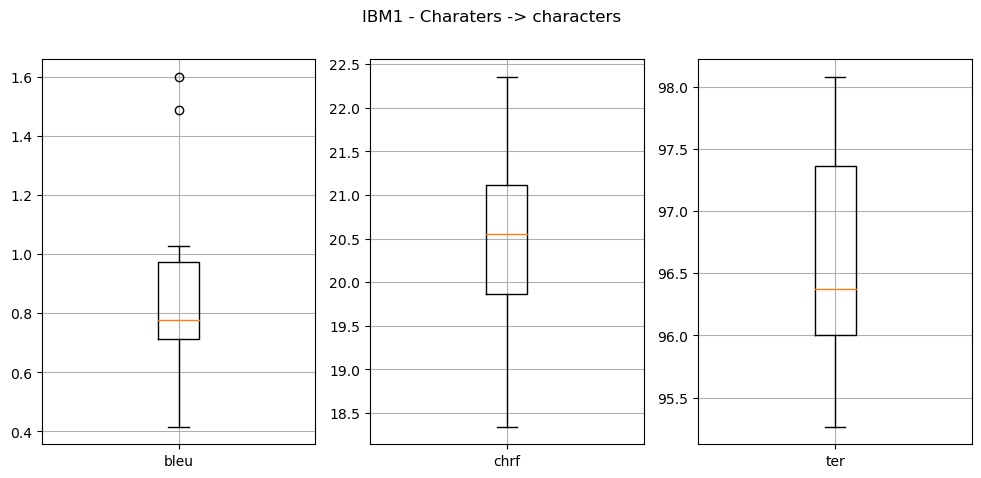

In [46]:
run_ibm(etruscan_char, english_char, ibm1_factory, "Results/ibm1_c_c.json", "IBM1 - Charaters -> characters", use_tok_sentences=False, join_str="")

100%|██████████| 10/10 [10:26<00:00, 62.62s/it]


Mean:
bleu     0.864925
chrf    20.366931
ter     96.843947
dtype: float64
Standard deviation:
bleu    0.364985
chrf    1.345601
ter     0.979691
dtype: float64
------------------------------------------------------------
Etruscan: ['l', 'e', 't', 'h', 'i', 'a', 'l']
Reference: s lethis
Prediction: lethial
------------------------------------------------------------


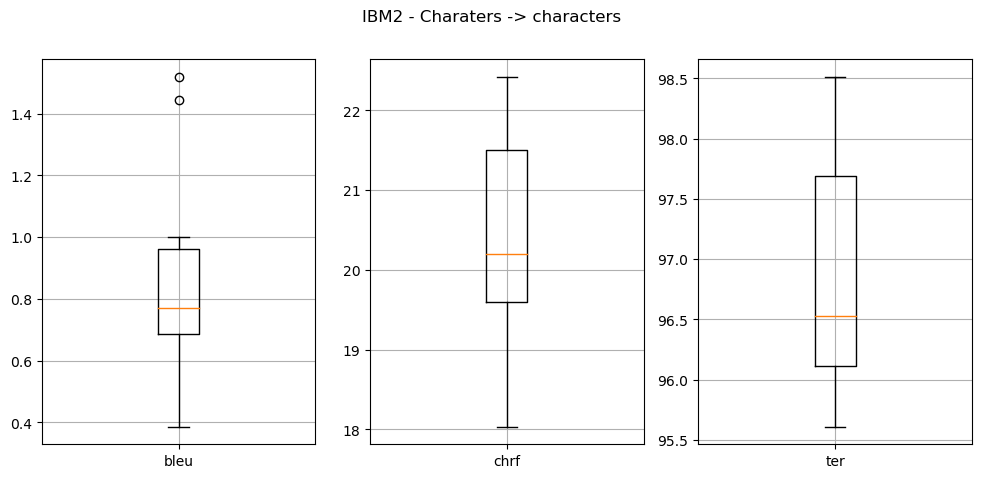

In [47]:
run_ibm(etruscan_char, english_char, ibm2_factory, "Results/ibm2_c_c.json", "IBM2 - Charaters -> characters", use_tok_sentences=False, join_str="")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [4:26:53<00:00, 1601.34s/it] 


Mean:
bleu     0.540758
chrf    19.062432
ter     99.764409
dtype: float64
Standard deviation:
bleu    0.143587
chrf    1.092056
ter     0.750461
dtype: float64
------------------------------------------------------------
Etruscan: ['l', 'e', 't', 'h', 'i', 'a', 'l']
Reference: s lethis
Prediction: lethial
------------------------------------------------------------


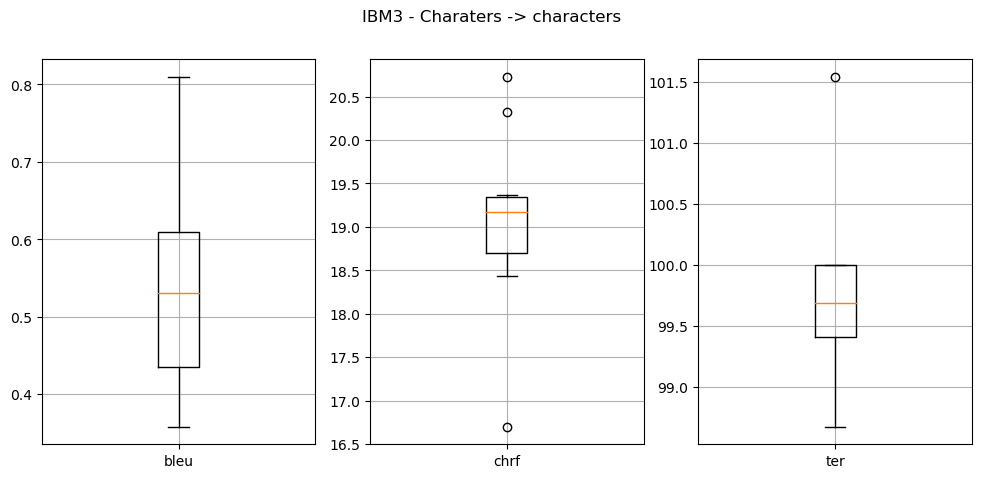

In [16]:
run_ibm(etruscan_char, english_char, ibm3_factory, "Results/ibm3_c_c.json", "IBM3 - Charaters -> characters", use_tok_sentences=False, join_str="", only_vocab=True)